# Mixed Models for ASM+Spikes+Synchrony

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
TABLES_DIRECTORY = "../../Data/giant_new_tables"

# Set up the seaborn style
sns.set_style("whitegrid")

In [3]:
# Initialize an empty list to hold the data
# completed_hup_ids = [160, 172, 141, 145, 157, 161, 138, 142, 151, 171, 175, 187]
completed_hup_ids = [
    160,
    172,
    # 141, # not enough time before first seizure
    145,
    138,
    142,
    151,
    187,
    180,
    184,
    # 192, # incomplete data
    # 196, # not enough time before first seizure
    # 204, # not enough time before first seizure
    # 165, # incomplete data
    # 169, # not enough time after the last seizure
    173,
    # 150, # not enough time before first seizure
    # 154, # incomplete data
    # 158, # incomplete data
    # 207, # not enough time before first seizure
    223,
    # 192,  ## Monday, August 21, 2023 additions this line and below # incomplete data
    # 196, # not enough time before first seizure
    # 204, # not enough time before first seizure
    177,
    185,
    # 189, # not enough time before first seizure
    # 205, # not enough time before first seizure
    166,
    # 170, # not enough time before first seizure
    # 174, # not enough time before first seizure
]
# Sort completed_hup_ids in ascending order
completed_hup_ids.sort()

In [4]:
def get_relevant_data(df, hours_before=12):
    # Find the first seizure time
    first_seizure_time = df[df["had_seizure"] >= 1]["emu_minute"].min()

    # Find the last seizure time
    last_seizure_time = df[df["had_seizure"] >= 1]["emu_minute"].max()

    # Calculate the start time for the 12-hour period before the first seizure
    start_time = (
        first_seizure_time - 2 * hours_before * 30
    )  # Since each row represents 2 minutes

    # Select the data for the period before the first seizure
    pre_seizure_data = df[
        (df["emu_minute"] >= start_time) & (df["emu_minute"] < first_seizure_time)
    ]

    # Select the data after the last seizure
    post_seizure_data = df[df["emu_minute"] > last_seizure_time]

    # Return the combined data
    return pd.concat([pre_seizure_data, post_seizure_data])


# Prepare dataframes for all patients
dfs = []
for patient_hup_id in completed_hup_ids:
    patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )

    # Only keep emu_minute, synchrony_broadband,med_sum_no_lorazepam_raw, and had_seizure columns
    patient_features_df = patient_features_df[
        [
            "emu_minute",
            "synchrony_broadband",
            "med_sum_no_lorazepam_raw",
            "time_since_last_seizure",
            "ad_ratio",
            "spike_rate",
            "spike_fano_factor",
            "spike_num_channels",
            "had_seizure",
        ]
    ]

    # Add a column for patient_hup_id
    patient_features_df["patient_hup_id"] = patient_hup_id

    # dfs.append(get_relevant_data(patient_features_df))
    dfs.append(get_relevant_data(patient_features_df))


# Combine them into one dataframe
all_data = pd.concat(dfs).reset_index(drop=True)
# drop rows with any missing values
all_data = all_data.dropna()
# Reset the index
all_data = all_data.reset_index(drop=True)

## Effect on synchrony from spikes

In [5]:
# Prepare the model
model = smf.mixedlm(
    "synchrony_broadband ~ spike_num_channels + spike_fano_factor + spike_rate + ad_ratio",
    all_data,
    groups=all_data["patient_hup_id"],
)

# Fit the model
result = model.fit()
print(result.summary())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: synchrony_broadband
No. Observations: 21076   Method:             REML               
No. Groups:       14      Scale:              0.0007             
Min. group size:  248     Log-Likelihood:     47007.1891         
Max. group size:  4192    Converged:          Yes                
Mean group size:  1505.4                                         
------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept           0.238     0.076   3.135  0.002   0.089   0.387
spike_num_channels  0.025     0.002  12.829  0.000   0.021   0.028
spike_fano_factor   0.000     0.000   1.685  0.092  -0.000   0.000
spike_rate          0.060     0.002  31.899  0.000   0.056   0.064
ad_ratio            0.003     0.000  12.056  0.000   0.003   0.004
Group Var       

rerun things without spikes

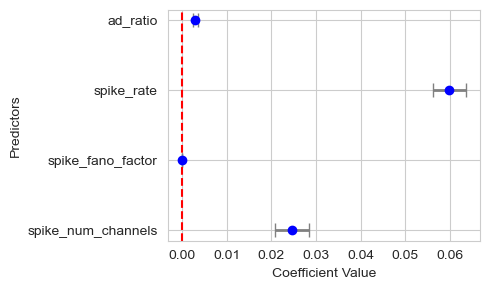

In [6]:
# Drop Group Var and Intercept from the results
coefficients = result.params.drop(["Group Var", "Intercept"]).values
predictors = result.params.drop(["Group Var", "Intercept"]).index
std_errors = result.bse.drop(["Group Var", "Intercept"]).values

# For a 95% confidence interval, z value is approximately 1.96
z_value = 1.96
conf_intervals = [
    (coef - z_value * se, coef + z_value * se)
    for coef, se in zip(coefficients, std_errors)
]

# Calculate lower and upper errors for each coefficient
lower_errors = [
    coef - ci_low for coef, (ci_low, ci_high) in zip(coefficients, conf_intervals)
]
upper_errors = [
    ci_high - coef for coef, (ci_low, ci_high) in zip(coefficients, conf_intervals)
]


# Create the coefficient plot
plt.figure(figsize=(5, 3))
for idx, (coef, predictor) in enumerate(zip(coefficients, predictors)):
    plt.errorbar(
        coef,
        idx,
        xerr=[[lower_errors[idx]], [upper_errors[idx]]],
        fmt="o",
        color="blue",
        ecolor="gray",
        elinewidth=2,
        capsize=5,
    )

# Formatting
plt.yticks(range(len(predictors)), predictors)
plt.axvline(0, color="red", linestyle="--")  # Add a vertical line for 0
plt.xlabel("Coefficient Value")
plt.ylabel("Predictors")
# plt.title("Mixed Model Coefficients with 95% Confidence Intervals")
plt.tight_layout()
plt.show()

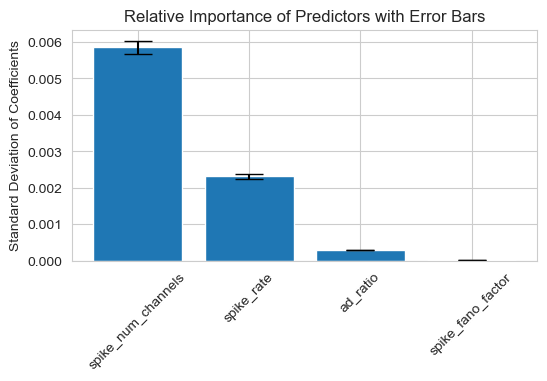

In [7]:
# Number of bootstraps
n_boots = 1000

# List of predictors
predictors = [
    "spike_num_channels",
    "spike_fano_factor",
    "spike_rate",
    "ad_ratio",
]
coefficients = {pred: [] for pred in predictors}

for _ in range(n_boots):
    # Sample data with replacement
    boot_data = all_data.sample(frac=1, replace=True)

    # Fit model on bootstrap sample
    model = smf.mixedlm(
        "synchrony_broadband ~ spike_num_channels + spike_fano_factor + spike_rate + ad_ratio",
        boot_data,
        groups=boot_data["patient_hup_id"],
    )
    result = model.fit()

    # Store coefficients
    for pred in predictors:
        coefficients[pred].append(result.params[pred])

# Calculate variability (standard deviation) of coefficients for each predictor
relative_importance = {pred: np.std(coefficients[pred]) for pred in predictors}

# Compute standard error for each predictor
standard_errors = {
    pred: std / np.sqrt(n_boots) for pred, std in relative_importance.items()
}

# Sort the predictors based on relative importance
sorted_predictors = sorted(
    relative_importance, key=relative_importance.get, reverse=True
)

# Visualization
plt.figure(figsize=(6, 3))
plt.bar(
    sorted_predictors,
    [relative_importance[pred] for pred in sorted_predictors],
    yerr=[standard_errors[pred] for pred in sorted_predictors],
    capsize=10,
)
plt.ylabel("Standard Deviation of Coefficients")
plt.title("Relative Importance of Predictors with Error Bars")
plt.xticks(rotation=45)  # Rotate predictor names for better readability
plt.show()

## Effect on spike rate from ASM

In [8]:
clause = "spike_rate ~ med_sum_no_lorazepam_raw + ad_ratio"

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     spike_rate
No. Observations:     21076       Method:                 REML      
No. Groups:           14          Scale:                  0.0083    
Min. group size:      248         Log-Likelihood:         20476.1430
Max. group size:      4192        Converged:              Yes       
Mean group size:      1505.4                                        
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 0.124    0.023   5.443 0.000  0.079  0.168
med_sum_no_lorazepam_raw -0.126    0.003 -41.922 0.000 -0.132 -0.120
ad_ratio                 -0.028    0.001 -31.938 0.000 -0.030 -0.026
Group Var                 0.007    0.031                            



/mnt/leif/littlab/users/devinma/Libraries/miniconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


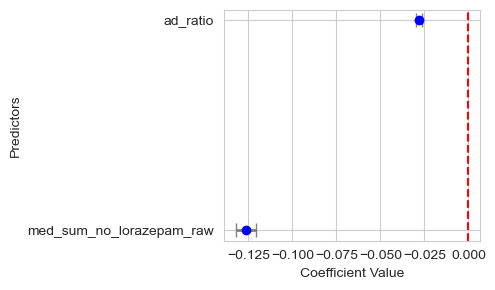

In [9]:
# Prepare the model
model = smf.mixedlm(
    clause,
    all_data,
    groups=all_data["patient_hup_id"],
)

# Fit the model
result = model.fit()
print(result.summary())

# Drop Group Var and Intercept from the results
coefficients = result.params.drop(["Group Var", "Intercept"]).values
predictors = result.params.drop(["Group Var", "Intercept"]).index
std_errors = result.bse.drop(["Group Var", "Intercept"]).values

# For a 95% confidence interval, z value is approximately 1.96
z_value = 1.96
conf_intervals = [
    (coef - z_value * se, coef + z_value * se)
    for coef, se in zip(coefficients, std_errors)
]

# Calculate lower and upper errors for each coefficient
lower_errors = [
    coef - ci_low for coef, (ci_low, ci_high) in zip(coefficients, conf_intervals)
]
upper_errors = [
    ci_high - coef for coef, (ci_low, ci_high) in zip(coefficients, conf_intervals)
]


# Create the coefficient plot
plt.figure(figsize=(5, 3))
for idx, (coef, predictor) in enumerate(zip(coefficients, predictors)):
    plt.errorbar(
        coef,
        idx,
        xerr=[[lower_errors[idx]], [upper_errors[idx]]],
        fmt="o",
        color="blue",
        ecolor="gray",
        elinewidth=2,
        capsize=5,
    )

# Formatting
plt.yticks(range(len(predictors)), predictors)
plt.axvline(0, color="red", linestyle="--")  # Add a vertical line for 0
plt.xlabel("Coefficient Value")
plt.ylabel("Predictors")
# plt.title("Mixed Model Coefficients with 95% Confidence Intervals")
plt.tight_layout()
plt.show()

within each patient, 

In [10]:
clause = "spike_fano_factor ~ med_sum_no_lorazepam_raw + ad_ratio"

               Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  spike_fano_factor
No. Observations:    21076    Method:              REML             
No. Groups:          14       Scale:               108.5941         
Min. group size:     248      Log-Likelihood:      -79348.3290      
Max. group size:     4192     Converged:           Yes              
Mean group size:     1505.4                                         
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                16.241    2.319   7.002 0.000 11.695 20.787
med_sum_no_lorazepam_raw -0.354    0.344  -1.029 0.304 -1.028  0.320
ad_ratio                 -1.211    0.100 -12.161 0.000 -1.406 -1.015
Group Var                75.010    2.847                            



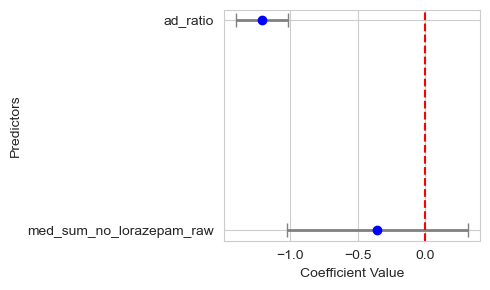

In [11]:
# Prepare the model
model = smf.mixedlm(
    clause,
    all_data,
    groups=all_data["patient_hup_id"],
)

# Fit the model
result = model.fit()
print(result.summary())

# Drop Group Var and Intercept from the results
coefficients = result.params.drop(["Group Var", "Intercept"]).values
predictors = result.params.drop(["Group Var", "Intercept"]).index
std_errors = result.bse.drop(["Group Var", "Intercept"]).values

# For a 95% confidence interval, z value is approximately 1.96
z_value = 1.96
conf_intervals = [
    (coef - z_value * se, coef + z_value * se)
    for coef, se in zip(coefficients, std_errors)
]

# Calculate lower and upper errors for each coefficient
lower_errors = [
    coef - ci_low for coef, (ci_low, ci_high) in zip(coefficients, conf_intervals)
]
upper_errors = [
    ci_high - coef for coef, (ci_low, ci_high) in zip(coefficients, conf_intervals)
]


# Create the coefficient plot
plt.figure(figsize=(5, 3))
for idx, (coef, predictor) in enumerate(zip(coefficients, predictors)):
    plt.errorbar(
        coef,
        idx,
        xerr=[[lower_errors[idx]], [upper_errors[idx]]],
        fmt="o",
        color="blue",
        ecolor="gray",
        elinewidth=2,
        capsize=5,
    )

# Formatting
plt.yticks(range(len(predictors)), predictors)
plt.axvline(0, color="red", linestyle="--")  # Add a vertical line for 0
plt.xlabel("Coefficient Value")
plt.ylabel("Predictors")
# plt.title("Mixed Model Coefficients with 95% Confidence Intervals")
plt.tight_layout()
plt.show()

The lower the ASM level (worse brain state), the lower the fano factor is, the more homogeneous the interspike intervals are. This makes sense.

In [12]:
clause = (
    "spike_num_channels ~ med_sum_no_lorazepam_raw + time_since_last_seizure + ad_ratio"
)

               Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  spike_num_channels
No. Observations:  21076    Method:              REML              
No. Groups:        14       Scale:               0.0086            
Min. group size:   248      Log-Likelihood:      20202.5480        
Max. group size:   4192     Converged:           Yes               
Mean group size:   1505.4                                          
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.004    0.003  1.488 0.137 -0.001  0.010
med_sum_no_lorazepam_raw -0.006    0.004 -1.562 0.118 -0.013  0.002
time_since_last_seizure   0.000    0.000  5.005 0.000  0.000  0.000
ad_ratio                 -0.003    0.001 -3.814 0.000 -0.005 -0.002
Group Var                 0.000    0.000                       

/mnt/leif/littlab/users/devinma/Libraries/miniconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


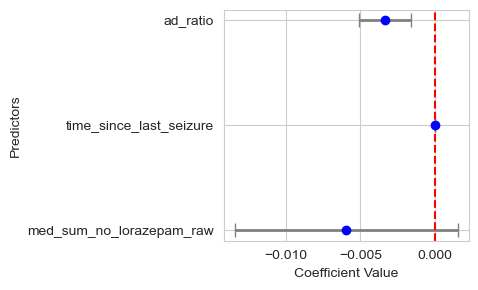

In [13]:
# Prepare the model
model = smf.mixedlm(
    clause,
    all_data,
    groups=all_data["patient_hup_id"],
)

# Fit the model
result = model.fit()
print(result.summary())

# Drop Group Var and Intercept from the results
coefficients = result.params.drop(["Group Var", "Intercept"]).values
predictors = result.params.drop(["Group Var", "Intercept"]).index
std_errors = result.bse.drop(["Group Var", "Intercept"]).values

# For a 95% confidence interval, z value is approximately 1.96
z_value = 1.96
conf_intervals = [
    (coef - z_value * se, coef + z_value * se)
    for coef, se in zip(coefficients, std_errors)
]

# Calculate lower and upper errors for each coefficient
lower_errors = [
    coef - ci_low for coef, (ci_low, ci_high) in zip(coefficients, conf_intervals)
]
upper_errors = [
    ci_high - coef for coef, (ci_low, ci_high) in zip(coefficients, conf_intervals)
]


# Create the coefficient plot
plt.figure(figsize=(5, 3))
for idx, (coef, predictor) in enumerate(zip(coefficients, predictors)):
    plt.errorbar(
        coef,
        idx,
        xerr=[[lower_errors[idx]], [upper_errors[idx]]],
        fmt="o",
        color="blue",
        ecolor="gray",
        elinewidth=2,
        capsize=5,
    )

# Formatting
plt.yticks(range(len(predictors)), predictors)
plt.axvline(0, color="red", linestyle="--")  # Add a vertical line for 0
plt.xlabel("Coefficient Value")
plt.ylabel("Predictors")
# plt.title("Mixed Model Coefficients with 95% Confidence Intervals")
plt.tight_layout()
plt.show()

The lower the ASM level (worse brain state), the more channels have spikes. Potentially related to spike cascades.